In [33]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw5.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 5: Language Modeling & Recurrent Neural Networks


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Pavlos Protopapas & Mark Glickman


<hr style="height:2pt">

In [34]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

In [35]:
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import layers
from keras import losses
from keras import optimizers
from keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from keras.layers import Input, Embedding, SimpleRNN, GRU, LSTM, TimeDistributed, Bidirectional, Dense
from keras.layers import  BatchNormalization, Activation, Dropout, GaussianNoise
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


# Added by me
import pickle
import pandas as pd
from keras.metrics import Precision, Recall


# Use mixed precision for optimal performance
#keras.mixed_precision.set_global_policy("mixed_float16")

In [36]:
# measure notebook runtime
time_start = time.time()

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">


### **PART 1: Character Level Text Generation**
    
Building a language model is a common task in natural language processing, and it involves training a machine learning algorithm to predict the probability of the next token in a sequence given the previous token(s). In the case of text generation, this model can be used to generate new text that is similar in style and tone to the original text used to train the model.
 
In the first part of this assignment, you'll be building a character level language model to generate text in the style of [Edward Lear](https://en.wikipedia.org/wiki/Edward_Lear) (1812-1888), a famous English writer and artist known for his humorous poetry and prose. 

<center>
    
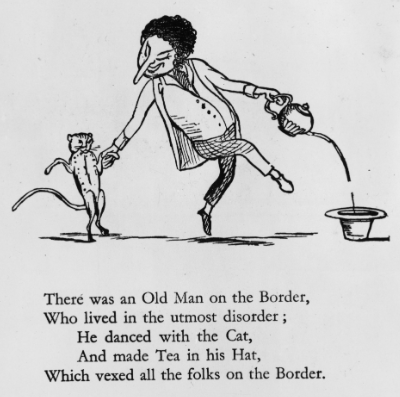

</center>
    
Lear's writing is particularly well-suited to text generation because of its playful and nonsensical nature. Lear often made use of invented words, portmanteaus, and other forms of wordplay, and his writing style is characterized by a sense of whimsy and playfulness that lends itself well to creative exploration.

Ready to get started? Let's dive in!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.1 - Reading & Cleaning the Text**
    
Read the contents of the file `data/edward_lear.txt` and store it in a variable called `text_raw`. The text contained in this file is an excerpt of content made available thanks to [Project Gutenberg](https://www.gutenberg.org/) and is distributed under their licence. Project Gutenberg is a great place to find texts for NLP projects.
    
    
*(The full text they distribute, data/pg13650.txt, is included in our files to adhere to their licence.)*
    
<br>    
    
Next, implement a function `text_clean` that converts a string to lowercase and replace any number of contiguous whitespace characters with a single space (e.g., `'\n\n'` -> `' '`). Use it on `text_raw` and save the result as `text`. This will make our langauge modeling task a bit simpler and the output of our text generation easier to read.
</div>

In [37]:
with open('../data/edward_lear.txt', 'r', encoding='utf-8') as file:
    text_raw = file.read()

In [38]:
# your code here

def text_clean(text_raw):
    text = text_raw.lower()
    text = re.sub(r'\s+', ' ', text)
    return text

In [39]:
text = text_clean(text_raw)

In [40]:
# Display length of cleaned corpus
print(f"Corpus length: {len(text):,}")

Corpus length: 133,762


In [41]:
grader.check("q1.1")

q1.1 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.2 - Character-Integer Mappings**

We will be building a character-level language model. Instead of treating words as tokens, we will treat each individual character as a token. This approach allows for more granular modeling of text, but it comes at the expense of increased computational complexity.

To make this possible, we need to create two-way character to integer mappings. We will assign each unique character in our text a unique integer identifier, and we will use this integer identifier to represent the character in our neural network. 

Your task is to create a sorted list called `chars` of all the unique characters in the processed `text` variable. Then, create two dictionaries: `char2idx` and `idx2char`. `char2idx` should map each unique character to its unique integer identifier, which is the index at which that character appears in `chars`. Conversely, `idx2char` should map each integer identifier to its corresponding unique character. These mappings will be essential for feeding our text data into the neural network, which requires numeric data.
</div>


In [42]:
# sorted unique char list
chars = sorted(set(text))

# char<>index mappings
char2idx = {char: idx for idx, char in enumerate(chars)}
idx2char = {idx: char for idx, char in enumerate(chars)}

In [43]:
# Display number of unique chars
print("Total chars:", len(chars))

Total chars: 57


In [44]:
grader.check("q1.2")

q1.2 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.3 - Input Sequence and Target Pairs**

Now that we have our character to integer mappings, we can begin creating our input sequence and target pairs. This process involves breaking up our text into fixed-length sequences, where each sequence is used to predict the character that follows that sequence in the text. 

Your task is to implement the code to generate these input sequence and target pairs using the following hyperparameters:
- `SEQ_LEN`: the length of each input sequence (default 100)
- `STEP`: the stride between each sequence (default 1)
    
For example, suppose our input text is "the owl and the pussy-cat went to sea". If `SEQ_LEN` is 5 and `STEP` is 2, we will create the following input sequences and target pairs:

| Input Sequence | Target Pair |
|---|---|
| `['t', 'h', 'e', ' ', 'o']` | `'w'` |
| `['e', ' ', 'o', 'w', 'l']` | `' '` |
| `['a', 'n', 'd', ' ', 't']` | `'h'` |
| `['h', 'e', ' ', 'p', 'u']` | `'s'` |
| `['t', 'y', '-', 'c', 'a']` | `'t'` |
| `[' ', 'w', 'e', 'n', 't']` | `' '` |
| `['t', 'o', ' ', 's', 'e']` | `'a'` |


You will need to create two numpy arrays: `x` and `y`. `x` should be an integer numpy array of shape (num_sequences, `SEQ_LEN`), where num_sequences is the total number of input sequences. Each element of `x` should be an integer representing the character at that position in the input sequence. `y` should be an integer numpy array of shape (num_sequences,), where each element is the integer representation of the target character for the corresponding input sequence.

After you have generated `x` and `y`, print their shapes and data types.
</div>

In [45]:
# your code here
SEQ_LEN = 100
STEP = 1

# Generate the input sequences and target pairs
sequences = []
target_chars = []

for i in range(0, len(text) - SEQ_LEN, STEP):
    sequences.append(text[i:i + SEQ_LEN])
    target_chars.append(text[i + SEQ_LEN])

# Convert the input sequences and target pairs into integer numpy arrays
num_sequences = len(sequences)

x = np.zeros((num_sequences, SEQ_LEN), dtype=np.int32)
y = np.zeros((num_sequences,), dtype=np.int32)

for i, sequence in enumerate(sequences):
    for j, char in enumerate(sequence):
        x[i, j] = char2idx[char]
    y[i] = char2idx[target_chars[i]]

In [46]:
# Display info of input sequences and targets
print("Number of sequences:", len(sequences))
print("x shape:", x.shape)
print("y shape:", y.shape)

Number of sequences: 133662
x shape: (133662, 100)
y shape: (133662,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.4 - Creating a TensorFlow Dataset Pipeline**

Now that we have prepared our input-output data, we need to create a TensorFlow dataset pipeline to feed it into our recurrent neural network. TensorFlow datasets provide an efficient and flexible way to handle large amounts of data and are particularly useful when working with deep learning models.

To create a TensorFlow dataset pipeline from our input-output data, we will use the `tf.data.Dataset.from_tensor_slices` method. This method takes a tuple of arrays or tensors and returns a dataset of slices along the first dimension. 

To optimize our training process, we will also shuffle our data, batch it into smaller chunks, and prefetch it to keep the GPU busy while the CPU is preparing the next batch. These operations should be performed in the following order: shuffle, batch, prefetch. Save this pipeline as `dataset`.

</div>


In [47]:
# your code here
BATCH_SIZE = 64
BUFFER_SIZE = len(x)
PREFETCH_SIZE = tf.data.AUTOTUNE

# Create the TensorFlow dataset pipeline
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(PREFETCH_SIZE)

In [48]:
# check the dataset
for x, y in dataset.take(2):
    print("x shape:", x.shape)
    print("y shape:", y.shape)

2023-04-20 14:17:54.536580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [133662]
	 [[{{node Placeholder/_1}}]]
2023-04-20 14:17:54.537064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [133662,100]
	 [[{{node Placeholder/_0}}]]


x shape: (64, 100)
y shape: (64,)
x shape: (64, 100)
y shape: (64,)


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.5 - Recurrent Neural Network**

Now it's time to build and compile our recurrent neural network! 

Your task is to construct a model with the Keras API that has the following architecture:

- The model should include at least one type of recurrent unit (check imports for some options).
- The output layer should have a `softmax` activation function, and output a probability distribution over each of the possible characters.
- Compile the model with an appropriate optimizer and loss function for the task.
- Display a summary of the model's architecture.

Make sure to consider the dimensions of `x` and `y` when constructing the model, and pay close attention to the input and output shape of the layers.
    
**Hints:**
- Your input sequences are currenlty sequences of intergers which are far from ideal and will likely lead to very poor performance. You could one-hot encode each character in the sequence as a sparse vector, but that (1) takes up more memory and (2) means all characters are orthogonal to one another. The best option would be to explore [Keras's Embedding layer](https://keras.io/api/layers/core_layers/embedding/) which will convert your integer input sequences into sequences of learnable, non-sparse vectors, allowing the model to represent some characters as similar to one another.
- Your targets are integers. You could one hot encode them to use categorical cross entropy as a loss, but this also takes up more memory. Better to explore what your [other loss options](https://keras.io/api/losses/) are for a scenario like this.
- Please feel free to experiement in your search for an optimal architecture and set of hyperparameters, but its bets to start of simple. In the final question of part 1 you will discuss the various approaches you tried.
</div>

In [49]:
x.shape

TensorShape([64, 100])

In [50]:
y.shape

TensorShape([64])

In [51]:
# your code here

# Model hyperparameters
VOCAB_SIZE = len(chars)
EMBEDDING_DIM = 256
SEQ_LEN = 100

# Build the model
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=SEQ_LEN),
    LSTM(256),
    Dense(VOCAB_SIZE, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'], run_eagerly=True)

# Display the model's architecture
model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 256)          14592     
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 57)                14649     
                                                                 
Total params: 554,553
Trainable params: 554,553
Non-trainable params: 0
_________________________________________________________________


2023-04-20 14:17:55.140259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-20 14:17:55.141841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-20 14:17:55.142997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
#### SECOND MODEL THAT WE TRIED

# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(input_dim=len(chars), output_dim=256, batch_input_shape=(BATCH_SIZE, SEQ_LEN)),
#     tf.keras.layers.LSTM(256, stateful=True, return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(256, stateful=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(len(chars), activation='softmax')
# ])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#               loss='sparse_categorical_crossentropy', 
#              run_eagerly=True)
# model.summary()

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.6 - Temperature**
    
When generating text with a language model, we want to balance between predictability and randomness. We use the notion of temperature to control the amount of randomness in the text. Here's how it works:

Given a probability distribution of the next character, the temperature is applied as a scaling factor to the log probabilities. This is done to adjust the shape of the distribution. A higher temperature means a flatter distribution, where all characters are equally likely, and a lower temperature means a sharper distribution, where the most probable character has a higher probability.

Your task is to implement a function called `sample` which takes in three arguments: `preds` - the probability distribution of the next character, `temperature` - the temperature to be applied, and `eps` - a small value to prevent us from taking the log of zero. It should return an integer corresponding to the index of the sampled character. Here's the formula for the sampling probabilities when applying temperature:

$$
\text{probas} = \frac{\exp{\big[\log{(\text{preds}_i)}\ /\ T\big]}}{\sum_j{\exp{\big[\log{(\text{preds}_j)}\ /\ T\big]}}}
$$
 
You will likely want to make use of numpy's logarithm and exponential functions as well as `np.random.multinomial` to implement `sample`.
    
</br>

**Note:** to avoid issues with numerical precission it may be necessary to convert `preds` to type np.int64.
</div>

In [53]:
def sample(preds, temperature=1.0, eps=1e-10):
    # Adjust the temperature parameter to avoid division by zero
    temperature = np.maximum(temperature, eps)
    # Apply the softmax function to obtain a probability distribution
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    probas = exp_preds / np.sum(exp_preds)
    # Normalize the probabilities so that they sum to 1.0
    probas /= np.sum(probas)
    # Sample a character index using the adjusted probabilities
    sampled_idx = np.random.multinomial(1, probas).argmax()
    return sampled_idx

In [54]:
grader.check("q1.6")

q1.6 results: All test cases passed!

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.7 - Text Generation Callback**

As we train our recurrent neural network, we want to be able to monitor its progress and see how well it is doing at each epoch. Looking at the loss can tell us if the model is improving, but it doesn't give us an idea of what the generated text looks like. By generating example text during training, we can get a sense of whether the model is producing text that is coherent and in the style of the training corpus.
    
Implement a function `generate_text` to be used as part of a lambda callback at the end of each training epoch.
    
**Function arguments**
- `epoch`: integer representing the current epoch number.
- `_`: internal keras callback parameter (not used in this function).

**Output**
- Prints generated strings and their corresponding temperatures.

**Function requirements**
- For each temperature value in `[0.2, 0.5, 1.0]`, perform the following steps:
    1. Sample a random, 'seed' sequence from the training data
    2. Print the seed sequence.
    3. Generate a string with 400 characters by iteratively:
        1. Predict the next character distribution by passing the numerically encoded seed sequence using the model.
        2. Use the `sample` function with the chosen temperature to select a character from the predicted distribution.
        3. Append the selected character to the end of the seed sequence and drop the first character.
    4. Print the generated string and its corresponding temperature.

Here is an example implementation scaffold of `generate_text` that you can use as a reference:
```python
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)
    
    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        ...

        # Step 2: Retrieve the seed sequence from the training text.
        ...
        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed + '"')

        # Initialize an empty string to store the generated text.
        generated = ""

        # Generate 400 characters.
        for i in range(400):
            ...
```
    
</div>

In [55]:
def generate_text(epoch, _):
    print()
    print("Generating text after epoch: %d" % epoch)

    for temperature in [0.2, 0.5, 1.0]:
        print("...Temperature:", temperature)

        # Step 1: Sample a random starting index from the training text.
        start_idx = np.random.randint(0, len(text) - SEQ_LEN - 1)

        # Step 2: Retrieve the seed sequence from the training text.
        seed = text[start_idx : start_idx + SEQ_LEN]

        # Step 3: Print the seed sequence.
        print('...Generating with seed: "' + seed + '"')

        # Initialize an empty string to store the generated text.
        generated = ""

        # Generate 400 characters.
        for i in range(400):
            # Convert the seed sequence to a numerical array
            seed_encoded = np.array([char2idx[c] for c in seed])
            seed_encoded = seed_encoded.reshape(1, -1)

            # Predict the next character distribution using the model
            preds = model.predict(seed_encoded)[0]

            # Use the sample function with the chosen temperature to select a character from the predicted distribution
            next_char_idx = sample(preds, temperature)

            # Convert the integer index of the next character back to its character representation
            next_char = idx2char[next_char_idx]

            # Append the selected character to the end of the seed sequence and generated string
            seed = seed[1:] + next_char
            generated += next_char

        print(generated)
        print()

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.8 - Training the Model with Lambda Callback**

Now that you have created a dataset pipeline, constructed your RNN, and implemented a function to generate text, it's time to train your RNN model on the data!

In order to monitor the training progress, use the `generate_text` function that you implemented in the previous question as part of a `LambdaCallback` to generate some sample text at 3 different temperature at the end of each epoch.

After training for at least 5 epochs, plot the training loss across epochs.
</div>

We trained the model using the below cell, then saved the model weights and training history as a `pickle` file and `.csv`, respectively. The latter was used to plot the training history and the weights were re-imported. 

In [56]:
# tf.config.run_functions_eagerly(True)

# #Training the RNN
# generate_text_callback = LambdaCallback(on_epoch_end=generate_text)

# EPOCHS = 10
# BUFFER_SIZE = 10000

# # Train the model
# history = model.fit(dataset, 
#                     epochs=EPOCHS, 
#                     callbacks=[generate_text_callback])

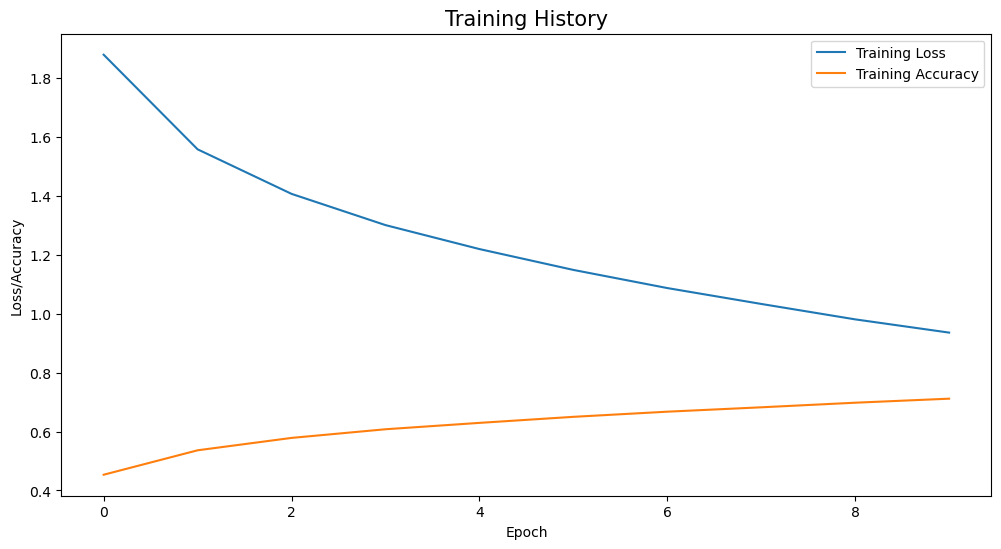

In [57]:
# Convert the history object to a DataFrame
#history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
#history_df.to_csv('rnn_training_history.csv', index=False)

# Plot training history

# Read in the CSV file containing the training history
history = pd.read_csv('rnn_training_history.csv')

# Plot the training loss and accuracy
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(history['loss'], label='Training Loss')
ax.plot(history['accuracy'], label='Training Accuracy')
ax.set_title('Training History', fontsize=15)
ax.set_ylabel('Loss/Accuracy')
ax.set_xlabel('Epoch')
ax.legend();

In [58]:
# define the path to the models directory
models_dir = '../models/'

# # save the weights of the model using pickle
# with open(models_dir + 'rnn_weights.pkl', 'wb') as f:
#     pickle.dump(model.get_weights(), f)

    
# Load the weights from file
with open(models_dir+'rnn_weights.pkl', 'rb') as f:
    weights = pickle.load(f)

# Set the weights of the model
model.set_weights(weights)

<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**1.9 - Perplexity for Language Models**
    
In natural language processing, perplexity is a commonly used metric to evaluate the quality of language models. It measures how well a model predicts a sequence of words (or characters in the case of our RNN), given a sequence of words. 
    
Perplexity is a measure of how surprised a model is to see an unseen sequence of words. It is related to entropy, a concept from information theory that measures the amount of information in a probability distribution. In fact, perplexity can be interpreted as the exponentiation of the entropy of a language model.
    
The formula for perplexity is:
    
$$\text{Perplexity} = 2^{-\frac{1}{N} \sum_{i=1}^N \log_2 P(w_i | w_1^{i-1}) }$$
    
where $N$ is the number of words (or characters) in the test set, and $P(w_i | w_1^{i-1})$ is the probability of the $i$-th word given the previous $i-1$ words.
    
A lower perplexity score indicates that the model is better at predicting the next word in a sequence. A perfect model would have a perplexity of 1, indicating that it is not at all surprised to see the next word in the sequence.
    
To implement a perplexity function for your character-level RNN, you can follow these steps:
1. Pass a sequence of input characters through the model to get the predicted probability distribution for the next character.
2. Calculate the cross-entropy loss between the predicted probability distribution and the actual target character.
3. Accumulate the loss for each character in the test set.
4. Compute the average loss across all characters in the test set.
5. Compute the perplexity score by exponentiating the average loss.
    
Below is a skeleton implementation for a possible perplexity function that takes in a trained model and a dataset of test sequences. The function returns the perplexity score of the model on the provided dataset. While less than ideal, because we have only the one small corpus, we will calculate perplexity on the training data.
    
```python
def calculate_perplexity(model, dataset):
    total_loss = 0
    steps = 0 # number of chars predicted on so far
    
    for x, y in dataset:
        # Get predictions from the model
        ...
        
        # Flatten the targets and predictions to 2D arrays
        ...
        
        # Calculate the loss and add it to the running total
        ...
        
    # Calculate the average loss and perplexity
    avg_loss = ...
    perplexity = ...
    
    return perplexity
```

**Hints:**
    
- If the calculation is slow you may consider adding an optional `batch_size` argument to your function which will `unbatch` and then re-batch the dataset with a higher batch size.
- You may be able to make use of a loss from `keras.losses` as part of your calculation
- If you are encoutering nans or infs you should make sure you are using higher precision variable types (e.g., `tf.float64`) to avoid under/overflow issues.
    
</div>

In [59]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [60]:
def calculate_perplexity(model, dataset, batch_size=None):
    if batch_size is not None:
        dataset = dataset.unbatch().batch(batch_size)
    
    total_loss = 0
    steps = 0 # number of chars predicted on so far

    loss_function = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    for x, y in dataset:
        # Get predictions from the model
        y_pred = model(x)

        # Flatten the targets and predictions to 2D arrays
        y = tf.reshape(y, [-1])
        y_pred = tf.reshape(y_pred, [-1, y_pred.shape[-1]])

        # Calculate the loss and add it to the running total
        loss = loss_function(y, y_pred)
        total_loss += tf.reduce_sum(loss).numpy()
        steps += len(y)

    # Calculate the average loss and perplexity
    avg_loss = total_loss / steps
    perplexity = np.exp(avg_loss)

    return perplexity

In [61]:
perplexity = calculate_perplexity(model, dataset, batch_size=64)

2023-04-20 14:17:55.971694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [133662]
	 [[{{node Placeholder/_1}}]]
2023-04-20 14:17:55.972185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [133662,100]
	 [[{{node Placeholder/_0}}]]


In [62]:
# Display final train perplexity
print(f"Train Perplexity: {perplexity:.2f}")

Train Perplexity: 31.19


<div class="alert alert-success" style="color: #333; background-color: #e6e6fa; border-color: #d8bfd8; border-width: 1px; border-radius: 3px; padding: 10px;">

**1.10 - Model Assessment**
    
Now, it's time to see what kind of wacky and wonderful text your model can generate!

Write any string of `SEQ_LEN` characters and use it as a seed to generate a longer sequence of text (at least 400 additional characters). Do this for at least 3 temperatures using the same seed. 
    
Next, discuss your approach to arriving at your final model architecture and hyperparameters. What did you find worked well based on loss, perplexity, and text generation, and what approaches didn't help or even made things worse?

Finally, assess how well your model generates text in the style of the Edward Lear corpus. Are there any noticeable patterns or quirks in the generated text? Did your model successfully capture the whimsical and nonsensical style of Edward Lear's writing?

</div>

We settled on choosing a LSTM for our task, which is in general good for sequence-to-sequence tasks and suitable for texte generation. Originally, one of the issues we were facing was the vanishing gradient issue, which it addressed and made it capable of learning longer sequences. We experimented with different types of RNN, including GRU, and finally settled on LSTM. 

We chose an embedding dimension of 256 after experimenting with different values and observing the tradeoff between model complexity and performance. 

Regarding the model architecture, the model consists of an Embedding layer, an LSTM layer, and a Dense output layer. The Embedding layer transforms input tokens into dense vectors, which are then fed into the LSTM layer. The LSTM layer learns the underlying patterns in the data. Finally, the Dense output layer generates a probability distribution over the vocabulary, with a softmax activation function. The model is evaluated based on the loss, perplexity, and text generation quality. 

We tried adding multiple other layers with dropout and batch normalization in a cell that we left commented out under the original model. However, it did not fare as well in regards to accuracy and perplexity score. We assume this is for various reasons related to charcter level text generation. 

Firstly, the first model is simpler and more straightforward than the second model. It consists of a single LSTM layer followed by a dense layer, while the second model has multiple LSTM layers with dropout and batch normalization.
Also, the first model has a fixed input length of 100 characters, which means it can generate text of a consistent length. The second model uses a stateful LSTM and has a variable input length, which can make it more difficult to generate consistent text.
Finally, the first model has a lower risk of overfitting compared to the second model because it has fewer layers and parameters.


**Regarding the generated text**:
The generated text has some similarities to Edward Lear's writing style in terms of using nonsense words and creating surreal images. However, there are also noticeable patterns and quirks that suggest that the model did not successfully capture the full whimsical and nonsensical style of Edward Lear's writing.

One of the most noticeable patterns is that the generated text often repeats phrases or words, such as "there was an old man" or "so was comeful". This repetition gives the text a somewhat mechanical or formulaic quality, which is not characteristic of Lear's writing.

Additionally, some of the generated sentences do not make grammatical sense or are difficult to parse, which is also not characteristic of Lear's writing. For example, "nothing so thangered pelly undlusing blyw" and "formed quite feer; fort a_ the pea-green veicht hono complicuous top?" are not coherent sentences.

Finally, increasing the temperature to 1.5 seems to produce even more nonsensical and disjointed text, with even more repetition and grammatical errors.


In [63]:
# Define the length of the sequence to generate
SEQ_LEN = 100

# Define the string to use as seed"There was an old man with a beard, who said AI is what we all feared, it learns so fast and with so much ease, it might take over the world with great sleaze."
seed_string = "AI has endless potential but ethical implications must be considered as we develop this technology."

In [64]:
# Set the seed string and number of characters to generate
num_chars = 400
seed_string = ''.join(c for c in seed_string if c in chars)

# Convert the seed string to a one-hot encoded sequence
seed_sequence = np.zeros((1, SEQ_LEN))
for i, char in enumerate(seed_string):
    seed_sequence[0, i] = char2idx[char]

generated_texts = {}
for temperature in [0.5, 1.0, 1.5]:
    print(f"Generating text at temperature {temperature}...")
    # Generate the text
    generated_text = ''
    for i in range(num_chars):
        # Predict the next character probabilities based on the current sequence
        preds = model.predict(seed_sequence)[0]
        # Sample the next character from the predicted probabilities using temperature
        next_idx = sample(preds, temperature=temperature)
        # Convert the index back to a character and add it to the generated text
        next_char = idx2char[next_idx]
        generated_text += next_char
        # Update the seed sequence with the new character
        seed_sequence[0, :-1] = seed_sequence[0, 1:]
        seed_sequence[0, -1] = next_idx

    generated_texts[temperature] = generated_text

Generating text at temperature 0.5...
1/1 [==============================] - 0s 28ms/step
Generating text at temperature 1.0...
1/1 [==============================] - 0s 31ms/step
Generating text at temperature 1.5...
1/1 [==============================] - 0s 27ms/step


In [65]:
print('Temperature = 0.5')
print(generated_texts[0.5])

Temperature = 0.5
[illustration] g was a little grand who lived in a calley, that all could not ase the whole world by the storks, and the seven young geese. [illustration] there was an old man of the dee, who frequented the choruse. [illustration] there was an old man of the west. [illustration] there was a young lady who sate hore of a large back to me. [illustration] there was an old person of dean who flew away


In [66]:
print('Temperature = 1.0')
print(generated_texts[1.0])

Temperature = 1.0
 nothing so thangered pelly undlusing blyw. but he said, "i'll sweet? wish him up, "covely, paster placed on the blue spoon: they sailed with a nide? oh, make a long as i fuga. [illustration] anver plumbnia.] far and there few away he are when cofore pranical of blue following elow pumpetty toilend coat. n! nime longs, mr. discuastains were no see. the dear from the changer lady of newry,-- who to


In [67]:
print('Temperature = 1.5')
print(generated_texts[1.5])

Temperature = 1.5
il suffley, sive fiundaly tree: formed quite feer; fort a_ the pea-green veicht hono complicuous top? he guy, which that is any old "what interfegents. mrended plump?s round be of fimpeth. b! but! some thush!" frimel in hour back so was comeful fowore cloce her selker; so his duck to cook with 4 kingly.; g!lorn?" iii. and he daily xigi's cake, he scuffen'd some supanchately, mnsinctian frum, they 


<div class="alert alert-success" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 30px;">
    
### **PART 2: Named Entity Recognition**
    
Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 
    
In the first part of the homework, you will build such a named entity classifier.  
    
The dataset consists of sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. For this homework, we will only use the ```Word``` and ```Tag``` columns. 
    
Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity
    
Named entity recognition is a type of "many-to-many" problem, refering to the fact that the model takes in a sequence of input tokens and produces a sequence of output tags, with potentially many input tokens mapping to many output tags, and vice versa. This contrasts with "many-to-one" models, where a sequence of input tokens maps to a single output (as in part 1), and "one-to-many" models, where a single input maps to a sequence of outputs.

---
    
First, read the dataset into a pandas dataframe using the provided code below.
</div>

In [68]:
# Load the NER data
file_path = "https://storage.googleapis.com/cs109b/nlp/ner_dataset.csv"
data = pd.read_csv(file_path,
                   encoding="latin1")
data = data.fillna(method="ffill")
print("Shape:",data.shape)
data.head(15)

Shape: (1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.1 PREPROCESS THE DATASET**

Of course, it wouldn't be a real NLP task without some preprocessing!
    
**2.1.1 - Creating the Vocabulary**
    
Create a list of unique words found in the 'Word' column, sorted it in alphabetic order, and call it `words`. Store the length of this list as ```n_words```. **Print your results for `n_words`**.
<br />
    
**Note:** Do not modify word capitalization, nor remove any numerical or special characters.
</div>

In [69]:
# your code here

words = sorted(set(data['Word']))
n_words = len(words)

In [70]:
# Run this cell to show your results for n_words
print(f'n_words: {n_words}')

n_words: 35178


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.2 - Unique Tags**
    
Create a list of unique tags and sort it in alphabetic order and store it in the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**.

</div>

In [71]:
# your code here
tags = sorted(data['Tag'].unique())
n_tags = len(tags)

In [72]:
# Run this cell to show your results for n_tags
print(n_tags)

17


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.3 - Sentences of Input-Target Pairs**
    
As mentioned above, NER is a many-to-many problem where for each input token in a sequence the model will try and predict the corresponding taget entity tag.
    
Process the data into a list, `sentences`, where each element of the list is itself a list of (word, tag) tuples. Here is an example of what the first sentence in the list should look like:

```
[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
```
</div>

In [73]:
# your code here

sentence_ender = ('.', '!', '?')

def split_words_into_sentences_and_tag_them(data):
    sentences = []
    current_sentence = []
    
    for _, row in data.iterrows():
        word = row['Word']
        tag = row['Tag']

        if word != '"':
            current_sentence.append((word, tag))

        if word.endswith(sentence_ender):
            sentences.append(current_sentence)
            current_sentence = []
    
    if current_sentence and not current_sentence[-1][0].endswith(sentence_ender):
        sentences.append(current_sentence)
    
    return sentences

sentences = split_words_into_sentences_and_tag_them(data)

In [74]:
# display you first sentence
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.4 - Maximum Sentence Length**
    
Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**
    
</div>

In [75]:
# your code here
max_len = np.max([len(sentence) for sentence in sentences])

In [76]:
# Run this cell to show your results for max_len
print(max_len)

104


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.5 - Word Encoding**
    
It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary that performs inverse mapping.
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
    
</div>

In [77]:
# your code here

# Create the word2idx dictionary, starting indices from 1
word2idx = {word: index+1 for index, word in enumerate(words)}

# Create the idx2word dictionary for the inverse mapping
idx2word = {index+1: word for word, index in word2idx.items()}

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.6 - Prepare X**
    
Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sentence encoded as a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
<br />
    
</div>

In [78]:
# your code here
# Prepare predictors list of lists
X = [[word2idx[word] for word, _ in sentence if word in word2idx] for sentence in sentences]

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.7 - Pad X**
    
Apply the keras ```pad_sequences``` function to standardize the length of input sequences and "pre" pad them with `0`. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. ```X[1]``` should now look like this:

```    
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  8193 27727 31033 33289 22577
 33464 23723 16665 33464 31142 31319 28267 27700 33246 28646 16052    21
 16915 17349  7924 32879 32985 18238 23555    24]
```

</div>

In [79]:
# your code here
# Apply the keras pad_sequences function
X = pad_sequences(X, maxlen=max_len, padding='pre', value=0)

In [80]:
# Run this cell to show your results #
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

Sentence 1: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  6284 27701 31968 25620 24854 33247
 19982 25518 33247 29400 34879 19045 18096 34972 32713 31831 17743  4115
 11465 11632 14986 17365 14485 33247  3882    25]

(56471, 104)


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1. - Tag Encoding**
    
Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.
<br />
    
**IMPORTANT:** Your indices should start at `1`. We will reserve `0` for later to represent padding.
</div>

In [81]:
# your code here

# Get the distinct tags from dataset
distinct_tags = sorted(set(tags))

tag2idx = {t: i+1 for i, t in enumerate(distinct_tags)}
# Create a dictionary mapping integers to tags
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

#idx2tag = {i+1: t for i, t in enumerate(tags)}

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.9 - Prepare Y**

Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
<br />
    
</div>

In [82]:
# your code here
Y = []
for s in sentences:
    y = [tag2idx[t[1]] for t in s]
    Y.append(y)
    
Y = np.array(Y)

/tmp/ipykernel_77/3745725099.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.array(Y)


In [83]:
print("Sentence 1: {}\n".format(Y[1]))
print(Y.shape)

Sentence 1: [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 7, 17, 17, 17, 17, 17, 17, 17, 17]

(56471,)


<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

**2.1.10 - Pad Y**
    
Apply the keras ```pad_sequences``` function to standardize the target sequences and 'pre' pad them with zeros. You should retrieve a matrix with all padded sentences' tags and length equal to the ```max_length``` previously computed. 
<br />
    
</div>

In [84]:
# your code here
# Apply the kera pas_sequences function

y = pad_sequences(Y, 
                  maxlen=max_len, 
                  padding='pre', 
                  value=0)

In [85]:
y.shape

(56471, 104)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.1.11 - Train / Validation / Test Split**
    
From the original dataset, construct a training, validation, and test set.
    
You should do this by making 2 calls to `train_test_split`. First, by splitting of 10% into test. Then by splitting 10% of what remains into validation with the rest being use for training. Use `random_state=109` for both your splits.
    
**Hint:** You may choose to turn your train and validation data into tensorflow Dataset objects for efficient training as in part 1.
    
</div>

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.1, 
                                                   random_state=109)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                 y_train, 
                                                 test_size=0.1, 
                                                 random_state=109)

In [87]:
print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('y_train shape', y_train.shape)
print('y_val shape', y_val.shape)

X_train shape (45740, 104)
X_val shape (5083, 104)
y_train shape (45740, 104)
y_val shape (5083, 104)


In [88]:
# Check for NaNs in training data
print(np.isnan(X_train).any())  # True
print(np.isnan(y_train).any())  # True
# Check for NaNs in val data
print(np.isnan(X_val).any())  # True
print(np.isnan(y_val).any())  # True

False
False
False
False


In [89]:
# Create TensorFlow Dataset objects for train and validation data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">

### **2.2 MODELLING THE DATA**

**2.2.1 - Build and fit the NER Model**

Now that you've prepared the train and test sets, you'll build a recurrent model which will include:

- An Embedding layer with input dimension equal to the number of unique tokens in the input sequences and output (embedding) dimension of 50
- A dropout layer with a dropout rate you find works well
- A Bidirectional Gated Recurrent Unit (GRU) layer where each direction's hidden state has a dimension of 100
- The final Dense layer (i.e., output layer) will have `units` equal to the number of unique tokens in the target sequences and an appropriate activation (consider the target dimensions).

After compiling the model, display the summary, train until you think you have achieved good results based on the loss and or any metrics you may be monitoring, and plot the training history.

**Hints:**
    
- We used `0` as our padding token. You can use `mask_zero=True` in the embedding layer to skip over any zeros in the input.  This will increase training speed (we also aren't interested in predicting the padding anyway).
- Remember that you have zeros in both your input and target sequences because of the padding. This will effect affect the required input and output dimensions of the network *even if you choose to mask the zeros*.
- Don't forget that this is a many-to-many problem where you are outputting sequences. Consider how this determines at least one argument required by your recurrent layer.
</div>

As we are dealing with a NER task, we consider monitoring additional metrics that are more specific to sequence labelling tasks, such as:

- Precision: The number of true positive predictions divided by the sum of true positive and false positive predictions.
- Recall: The number of true positive predictions divided by the sum of true positive and false negative predictions.
- F1 Score: The harmonic mean of precision and recall, which provides a single metric that balances both precision and recall.

In [90]:
# Build model & display summary
# your code here

batch_size = 32
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the model
ner = Sequential([
    Input(shape=(104,)),
    Embedding(input_dim=n_words+1, 
              output_dim=50, 
              input_length=104, 
              mask_zero=True),
    Dropout(rate=0.1),
    Bidirectional(GRU(units=100, return_sequences=True)),
    Dense(units=n_tags+1,
          activation='softmax',
          #kernel_regularizer=regularizers.l2(0.01))
         )])

# Compile the model
ner.compile(optimizer=optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Display the model summary
ner.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 104, 50)           1758950   
                                                                 
 dropout (Dropout)           (None, 104, 50)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         91200     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 104, 18)           3618      
                                                                 
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Train model
# your code here
epochs = 5
history = ner.fit(train_dataset, 
                    validation_data=val_dataset, 
                    batch_size=32,epochs=epochs)


Epoch 1/5


2023-04-20 14:20:13.465127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [45740,104]
	 [[{{node Placeholder/_1}}]]
2023-04-20 14:20:15.682155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-04-20 14:20:18.565293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for

1430/1430 [==============================] - ETA: 0s - loss: 0.2720 - accuracy: 0.9331

2023-04-20 14:29:04.559243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [5083,104]
	 [[{{node Placeholder/_1}}]]


1430/1430 [==============================] - 540s 370ms/step - loss: 0.2720 - accuracy: 0.9331 - val_loss: 0.1236 - val_accuracy: 0.9631
Epoch 2/5
1430/1430 [==============================] - 504s 353ms/step - loss: 0.0973 - accuracy: 0.9696 - val_loss: 0.1127 - val_accuracy: 0.9665
Epoch 3/5
1430/1430 [==============================] - 505s 353ms/step - loss: 0.0760 - accuracy: 0.9755 - val_loss: 0.1142 - val_accuracy: 0.9663
Epoch 4/5
1430/1430 [==============================] - 502s 351ms/step - loss: 0.0644 - accuracy: 0.9786 - val_loss: 0.1229 - val_accuracy: 0.9658
Epoch 5/5
1430/1430 [==============================] - 502s 351ms/step - loss: 0.0559 - accuracy: 0.9813 - val_loss: 0.1324 - val_accuracy: 0.9651


In [92]:
models_dir = '../models/'

# save the weights of the model
# with open(models_dir + 'ner_weights.pkl', 'wb') as f:
#     pickle.dump(ner.get_weights(), f)
    
# Load the weights from file
with open(models_dir+'ner_weights.pkl', 'rb') as f:
    weights2 = pickle.load(f)

In [93]:
# Set the weights of the model
ner.set_weights(weights2)

In [94]:
# ner_history_df = pd.DataFrame(history.history)
# # Save the DataFrame to a CSV file
# ner_history_df.to_csv('ner_training_history.csv', index=False)

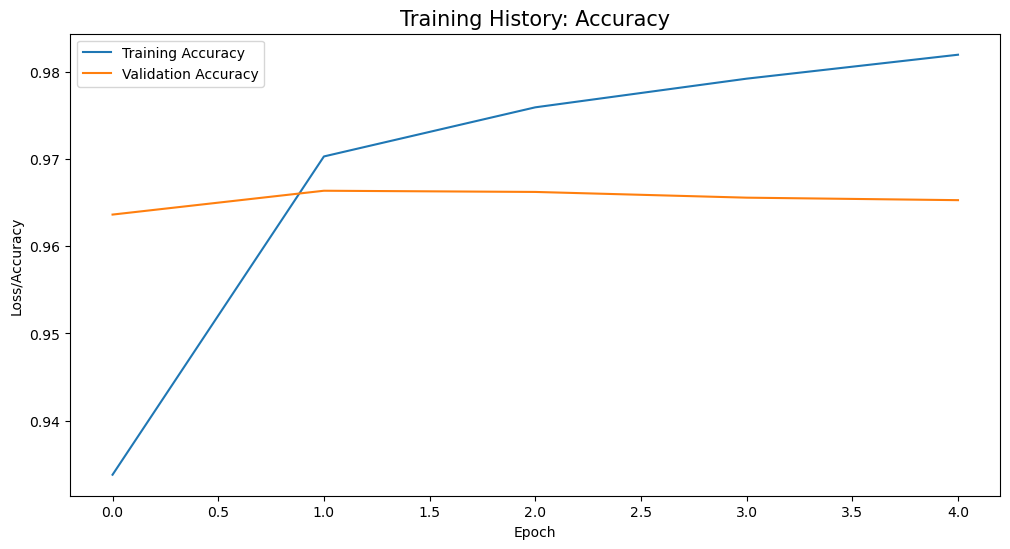

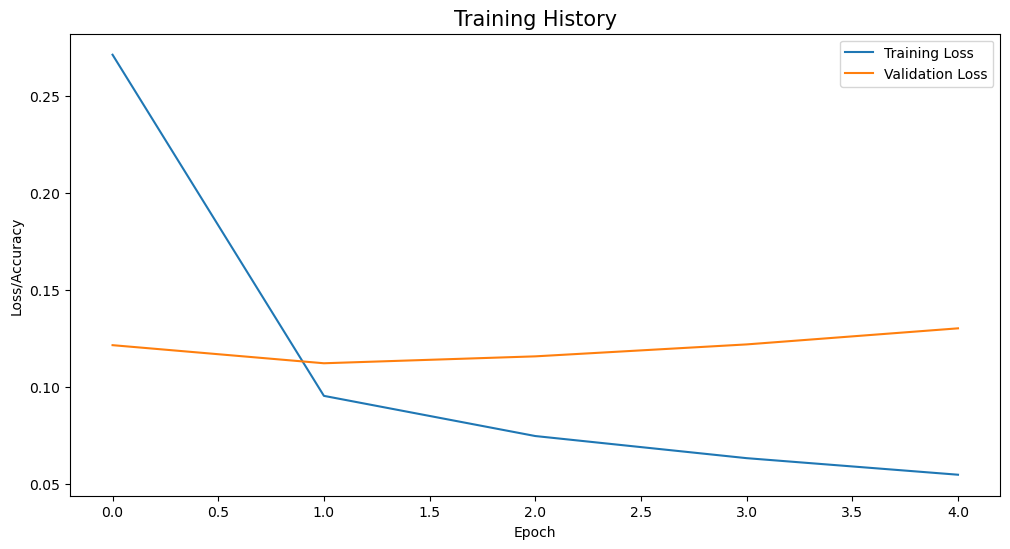

In [95]:
# Plot training history

# Read in the CSV file containing the training history
ner_history = pd.read_csv('ner_training_history.csv')

# Plot the training loss and accuracy
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ner_history['accuracy'], label='Training Accuracy')
ax.plot(ner_history['val_accuracy'], label='Validation Accuracy')
ax.set_title('Training History: Accuracy', fontsize=15)
ax.set_ylabel('Loss/Accuracy')
ax.set_xlabel('Epoch')
ax.legend();

# Plot the training loss and accuracy
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ner_history['loss'], label='Training Loss')
ax.plot(ner_history['val_loss'], label='Validation Loss')
ax.set_title('Training History', fontsize=15)
ax.set_ylabel('Loss/Accuracy')
ax.set_xlabel('Epoch')
ax.legend();

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.2.2 - Visualizing the Latent Space**

Some would argue that neural networks are all about representation learning. Let's see how your network represents each sequences.
    
Visualize outputs from the bidirectional GRU layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.
    
You can make use of the two functios provided below to make your plots, but make sure you understand the arguments taken by `get_hidden_ouput_PCA`, especially `index_layer`, the index of the layer in your network whose outputs we want to visualize, and `out_dim`, the output dimensions of that layer at a single timestep.

</div>

In [96]:
# Helper functions
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = y_test.flatten()
    unique_categories = np.unique(category)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in unique_categories[8*i:8*(i+1)]:
            indices = np.where(category==cat+1)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat+1],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("PC1")
        ax[i].set_ylabel("PC2")
        ax[0].set_title('B-tags')
        ax[1].set_title('I-tags')
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
 

def get_hidden_output_PCA(model, X_test, y_test, layer_index, out_dimension):
    latent_space_extractor = Model(model.inputs, model.layers[layer_index].output)
    hidden_feature=np.array(latent_space_extractor([X_test]))

    hidden_feature=hidden_feature.reshape(-1, out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print(f'Variance explained by PCA: {np.sum(pca.explained_variance_ratio_):.2%}')
    return pca_result

In [97]:
pca = get_hidden_output_PCA(ner, X_test, y_test, layer_index = 2, out_dimension=200)

Variance explained by PCA: 67.46%


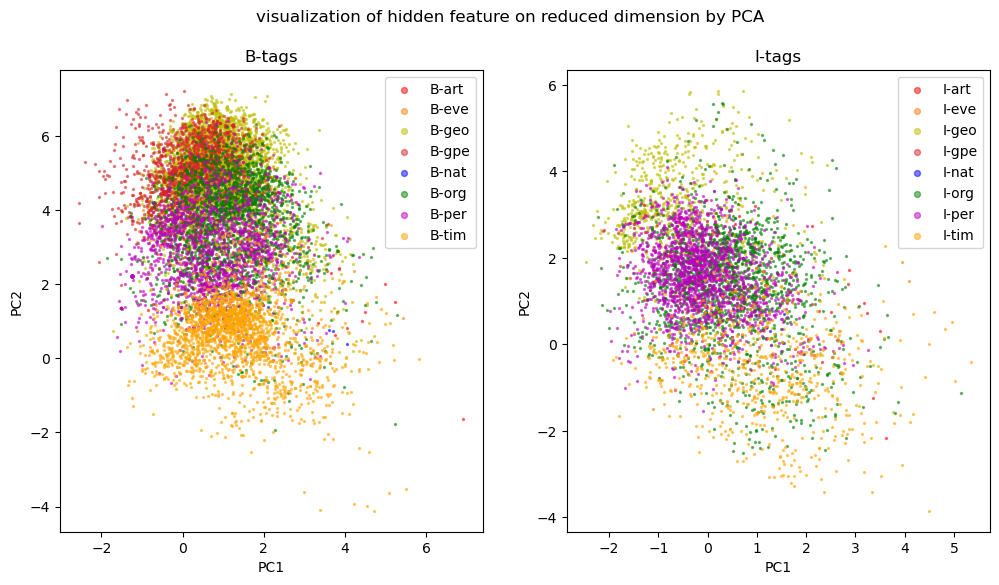

In [98]:
visualize_B_I(pca)

To interpret the output plot, one may look at the distribution of the data points in the 2D space. Points that are closer together are more similar to each other in terms of the hidden features extracted by the neural network.

The colors of the points represent the different classes of the input data.  If there is a clear separation between the classes, that indicates that the model has learned to extract meaningful hidden features that distinguish between the different classes. If the classes are mixed together in the reduced space, that could indicate that the neural network is not able to distinguish between the classes very well.

In light of this, the network seems to have extracted meaningful hidden features for the B-tags but not for the I-tags. This could mean that the network is able to recognize the patterns that correspond to the beginning of a named entity, but is not able to recognize the patterns that correspond to the continuation of a named entity. 

<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
### **2.3 MODEL ANALYSIS**
    
**2.3.1 - Computing & Plotting F1 Scores**

Let's get a better sense of how well out model is doing at predicting each of the different tag categories.
    
Use your trained NER model to predict on the test dataset. Compute an F1 score for each unique ```Tag``` category and store them in `f1_scores`.
    

The use a well-labeled bar plot to visualize the model's test F1 scores for each Tag category.

</div>

In [99]:
# Calculate F1 scores
# Your code here

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

f1_score = F1Score()


177/177 [==============================] - 10s 44ms/step


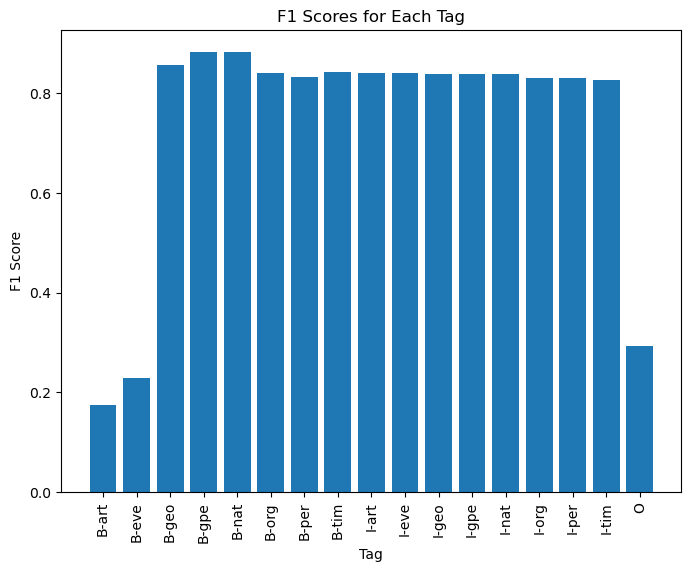

In [100]:
# Plot F1 scores
# Your code here

y_pred = ner.predict(X_test)
y_pred_argmax = y_pred.argmax(axis=-1).ravel()


# Calculate F1 score for each tag
f1_scores = []
for tag in tag2idx.keys():
    tag_idx = tag2idx[tag]
    y_true = (y_test == tag_idx).astype(int)
    y_pred = (y_pred_argmax == tag_idx).astype(int)
    f1 = f1_score(y_true.flatten(), y_pred.flatten())
    f1_scores.append(f1)

# Plot F1 score for each tag
plt.figure(figsize=(8, 6))
plt.bar(tag2idx.keys(), f1_scores)
plt.title('F1 Scores for Each Tag')
plt.xlabel('Tag')
plt.ylabel('F1 Score')
plt.xticks(rotation=90)
plt.show()



<div class="alert alert-info" style="color: #333; background-color: #e6ffe6; border-color: #c3e6cb; border-width: 1px; border-radius: 3px; padding: 10px;">
    
**2.3.2 - Discussion**

Briefly discuss the performance of the model across the various tag categoies. Does anything stand out to you about the visualization. Does it seem like a problem? If so, what might be done to address this in future iterations of the NER model?

</div>

The performance of the model across the various tag categories appears to be better for I-tags than for B-tags, as evidenced by the average higher F1-scores for I-tags in the plot. This could indicate that the model is better at recognizing named entities that occur in the middle of a sentence (which are labeled with I-tags), compared to named entities that occur at the beginning of a sentence.

However, it may be worth noting that there is a certain contradiction here as the model seems to be proficient in classifying B-tags at first, but then better at classifying I-tags, depending on the kind of analysis. One possible explanation for this contradiction is that the model may be better at recognizing the patterns associated with B-tags for certain named entity types, but not for others. This could result in the higher F1 scores for I-tags, even though the PCA plot shows a clear separation between B-tag classes.

To address this issue in future iterations of the NER model, one approach could be to gather more labeled data that includes a greater diversity of B-tags and I-tags, with the goal of training the model to better distinguish between the two types of tags. Another approach could be to modify the architecture of the network to explicitly capture the different patterns associated with B-tags and I-tags. For example, the network could be designed to include separate layers for B-tags and I-tags, or to use attention mechanisms that give more weight to the beginning of a named entity when a B-tag is present. 



<div class="alert alert-info" style="color: #4a4a4a; background-color: #f7dfe6; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

I worked on this assignment alone, and had the most trouble figuring out the model architectures. 

In [101]:
hours_spent_on_hw = 20

In [102]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [103]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 45.25 minutes for this notebook to run


**This concludes HW5. Thank you!**


<center>
    
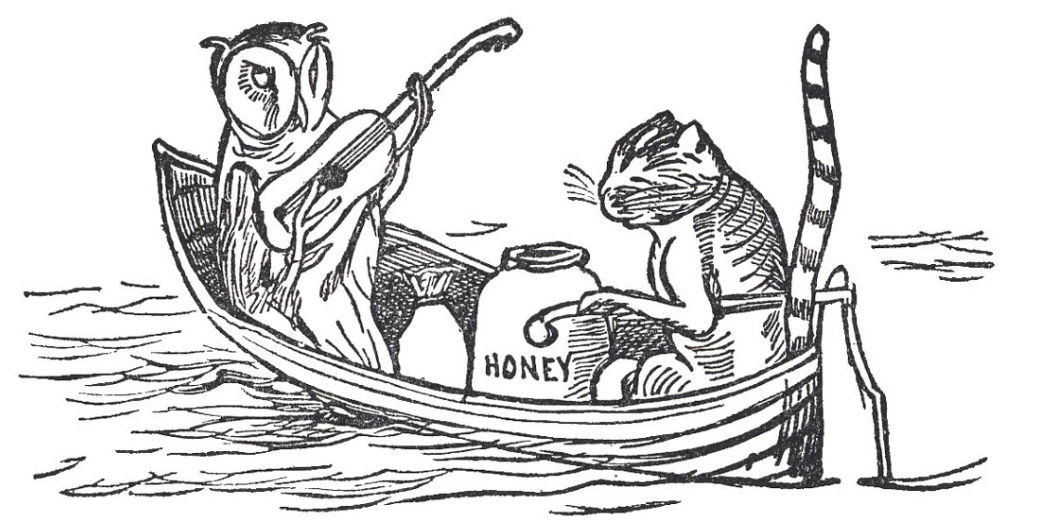
    
</center>